# Parallel Scientific Computing II

## Multigrid
    
#### Anne Reinarz

# Recall

- Smoothers good for reducing high-frequency errors
- Otherwise very slow convergence


### Observation

What is "high-frequency" depends on the number of points in the grid

#### Basic Idea

Choose multiple grids, each reducing the errors of a certain frequency

# 2D Multigrid for Darcy Flow

We are going to look at the Darcy flow equation, discretized with a simple finite elements scheme on a hierarchical quad-tree based grid.


- steady state Darcy flow equation.
    - This equation states the law of fluid flow through a porous medium, e.g. through sand.




# 2D Multigrid for Darcy Flow


We have 
- the steady-state fluid pressure $u$
- the spatially varying permeability $K(x,y)$.

The PDE is basically a variable-coefficient version of the Poission equation and looks like:
$$- \nabla \cdot \left(K(x,y) \nabla u \right) = f,
\qquad \forall \mathbf{x} \in \Omega
$$
with boundary conditions
\begin{align}
u(x,y) &= 0 \qquad \forall x \in \Gamma_D \\
-K(x) \nabla u \cdot n &= 0 \qquad \forall x \in \Gamma - \Gamma_D
\end{align}
where $\Gamma$ is the boundary and $\Gamma_D$ is the Dirichlet part of the boundary.

The Dirichlet boundary is on the top of the domain, all other boundary conditions are set to Neumann.


# The grid
We define a quadtree-based grid, as this allows us to perform hierarchical algorithms with ease.
Briefly, we decompose the domain into squares.

# Discretization
For the discretization we use a finite element approach. As in finite differences we end up with a stiffness matrix $A_{ij}$ and a right-hand side $f_{i}$, where $i$ and $j$ are indices of vertices.
It is important to note here that we remove rows and columns where either $i$ or $j$ corresponds to a vertex where the Dirichlet boundary condition is enfored.
We do this to ensure that the remaining system is symmetric.

This is all you need to know about the discretization to finish this notebook. The implementation of finite elements can be found in the src directory of the git repository for the lecture.

In [21]:
%matplotlib inline
import numpy as np


import scipy.special as special
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import patches

import sys
sys.path.append("src/")

import quadtree
import plotter
import fem

In [22]:
class Geometry:
    def __init__(self, level):
        center = np.array([0.5, 0.5])
        size = 1.0
        self.grid = quadtree.Quadtree(center=center, size=size)
        self.grid.split_to_level(level)
       
        self.vertices_coords_to_idx, \
        self.number_of_vertices_per_level, \
        self.boundary_vertices = self.grid.get_vertices()
        self.vertices_idx_to_coords = {v: k for k, v in self.vertices_coords_to_idx.items()}
        self.grid.set_all_cell_vertices(self.vertices_coords_to_idx)
        self.grid.set_all_cell_indices()
        
        self.dirichlet_vertices = set()
        for v in self.boundary_vertices:
            eps = 1e-8
            if self.vertices_idx_to_coords[v][1] >= (1 - eps):
                self.dirichlet_vertices.add(v)
        
        dirichlet_vertices_array = np.array([*self.dirichlet_vertices])
        # We do not store the data for Dirichlet values
   
        self.data_size_per_level = []
        for level in range(self.grid.get_max_level()+1):
            n_vert = self.number_of_vertices_per_level[level]
            n_dirichlet_vert = len(
                dirichlet_vertices_array[
                    dirichlet_vertices_array < n_vert])
            self.data_size_per_level.append(n_vert - n_dirichlet_vert)
            
        
        self.vertex_idx_to_data_idx = np.zeros(self.number_of_vertices_per_level[-1], dtype=np.int32)
        self.data_idx_to_vertex_idx = np.zeros(self.data_size_per_level[-1], dtype=np.int32)
        cur_data_idx = 0
        for i in range(self.number_of_vertices_per_level[-1]):
            if i in self.dirichlet_vertices:
                self.vertex_idx_to_data_idx[i] = -1
            else:
                self.vertex_idx_to_data_idx[i] = cur_data_idx
                self.data_idx_to_vertex_idx[cur_data_idx] = i
                cur_data_idx += 1       
        

geometry = Geometry(level=4)
geometry.number_of_vertices_per_level[0]

4

## Solving the system for a single level
Below we show how to setup a discretization, geometry and stiffness matrix and rhs.
We also show how to compute a solution with a direct solver.

In [3]:
# Use a simple material
def eval_k(x,y):
    return x + y

level = 4
geometry = Geometry(level=4)
discretization = fem.Discretization(geometry,level=level,eval_k=eval_k)
stiffness = discretization.setup_stiffness()
rhs = discretization.setup_rhs()
sol = splinalg.linsolve.spsolve(stiffness, rhs)

# System is solved correctly to double precision:
np.linalg.norm(stiffness @ sol - rhs)

8.332014642235895e-15

## Plotting the solution
You can visualize the solution with *plot_solution* as below.
It also kept in the notebook as a further example of a grid traversal, for the evaluation of the basis functions and for the handling of Dirichlet boundary conditions.

The left plot shows the solution, the right one shows the material parameter.
Dirichlet vertices are marked with black x.

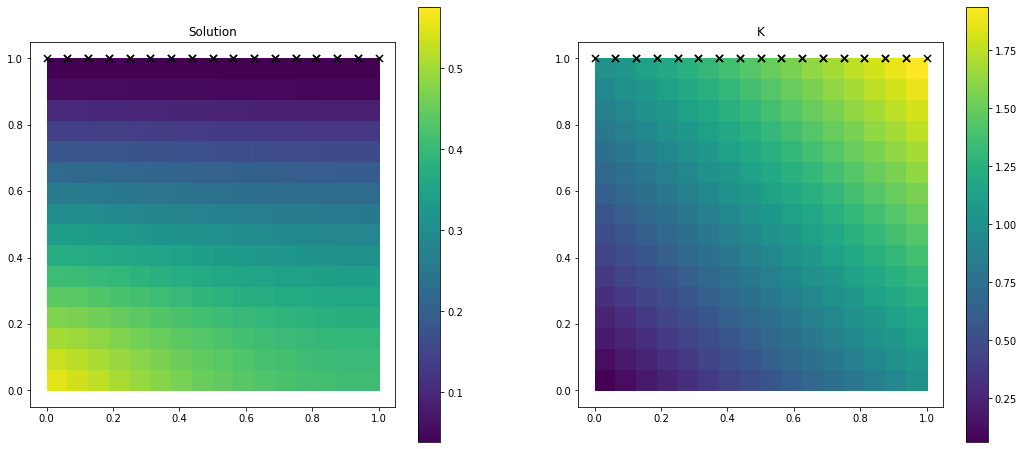

In [4]:
def plot_solution(geometry, discretization, sol, level):
    # First find minimum and maximum material parameter
    min_k, max_k = float('inf'), float('-inf')
    for cell in geometry.grid.dfs(only_level=level):
        k = discretization.eval_k(cell.center[0], cell.center[1])
        min_k = min(k, min_k)
        max_k = max(k, max_k)

    # Set up color scales for the solution and the material k.
    norm_solution = mpl.colors.Normalize(vmin=sol.min(), vmax=sol.max())
    norm_k = mpl.colors.Normalize(vmin=min_k, vmax=max_k)
    cmap = cm.viridis
    color_mapper_solution = cm.ScalarMappable(norm=norm_solution, cmap=cmap)
    color_mapper_k = cm.ScalarMappable(norm=norm_k, cmap=cmap)

    fig, axs = plt.subplots(1,2, figsize=(18,8))
    
    # Lists to store Dirichlet vertices.
    dirichlet_xs = []
    dirichlet_ys = []

    for cell in geometry.grid.dfs(only_level=level):
        value = 0.0
        # Evaluate all basis functions at (0.5, 0.5)
        for i, vertex in enumerate(cell.vertices):
            # Ignore dirichlet boundary conditions.
            # Their value is not stored and is always zero.
            if vertex not in geometry.dirichlet_vertices:
                # Here we get the index of the data correspond to the vertex.
                data_idx = geometry.vertex_idx_to_data_idx[vertex]
                value += sol[data_idx] * fem.lagrange_2d(discretization.nodes_x, i, (0.5,0.5))

        # Plot the rectangles that build up the grid.
        rect = patches.Rectangle(
            cell.offset,
            cell.size,
            cell.size,
            fill=True,
            color=color_mapper_solution.to_rgba(value))
        axs[0].add_patch(rect)

        # Plot material
        value = discretization.eval_k(cell.center[0], cell.center[1])
        rect = patches.Rectangle(
            cell.offset,
            cell.size,
            cell.size,
            fill=True,
            color=color_mapper_k.to_rgba(value))
        axs[1].add_patch(rect)    

        # Find dirichlet vertices
        for v in cell.vertices:
            if v in geometry.dirichlet_vertices:
                dirichlet_xs.append(geometry.vertices_idx_to_coords[v][0])
                dirichlet_ys.append(geometry.vertices_idx_to_coords[v][1])
                
    axs[0].set_title("Solution")
    axs[0].axis('square')

    axs[1].set_title("K")
    axs[1].axis('square')

    # Mark Dirichlet vertices with black x.
    for ax in axs:
        ax.scatter(dirichlet_xs, dirichlet_ys, c='black', zorder=10, marker='x', s=50)
        
    fig.colorbar(color_mapper_solution, ax=axs[0])    
    fig.colorbar(color_mapper_k, ax=axs[1])

plot_solution(geometry=geometry, discretization=discretization, sol=sol, level=level)

# A nested iteration

Instead of a full multigrid method, lets start with a simpler idea. We could solve on a coarse grid in order to get a starting guess for the finer grid.


# A nested iteration


### Algorithm:
1. Start on a very coarse grid with mesh size $h = h_0$ and guess an initial solution $x_h$
        
2. Iterate over $A_h x_h = b_h$ using relaxation method to get an approximate solution $x_h$
        
3. interpolate the solution $x_h$ to a finer grid with mesh width $h/2$

4. proceed with step 2 (now with mesh size $h := h/2$) using interpolated $x_{h/2}$ as initial solution


# A nested iteration


### Ingredients
1. smoother: reduce the high-frequency error components, and get a smooth error
2. coarse grid equation: discretisation of the PDE on the coarse grid
3. interpolation: transfer coarse grid solution/correction from coarse grid to fine grid

Let's go through these three ingredients step by step.



## 1. Smoothers
The next step towards multigrid is defining the smoother.
Here, we want to use a simple Jacobi relaxation. Recall from the precious lecture that we split the matrix $A$ into a diagonal and an off-diagonal part as
$$A = D + O.$$
We can then write one Jacobi update as
$$x^{n+1} = D^{-1} (b - O x^{n}).$$

Let's recall the implemenation (here modified to use sparse matrices for performance):

In [23]:
def jacobiRelaxation(A, b, x0, max_iter):
    diagonal_part = sp.diags(A.diagonal())
    diagonal_part_inv = sp.diags(1/A.diagonal())
    rest = A - diagonal_part
    x = x0
    for i in range(max_iter):
        x = diagonal_part_inv @ (b - rest @ x)
    return x

In [24]:
def compute_residual(A, x, b):
    return np.linalg.norm(A @ x - b)

## 2. Coarse Matrix

Next let's create our coarse grid one level smaller than the fine grid (of max_level).

But first let's take a look at a single cell and the corresponding fine cells:

Text(0.5, 1.0, 'Corresponding Fine Cell')

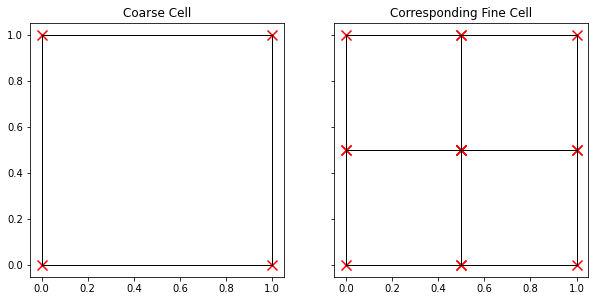

In [7]:
# Take the first and only cell of level 0.
cells = list(geometry.grid.dfs(only_level=0))
c = cells[0]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,10))
plotter.plot_grid(fig, axs[0], grid=c, level=0, vertices=geometry.vertices_idx_to_coords, plot_vertices=True)
plotter.plot_grid(fig, axs[1], grid=c, level=1, vertices=geometry.vertices_idx_to_coords, plot_vertices=True)
axs[0].axis('square')
axs[0].set_title("Coarse Cell")
axs[1].axis('square')
axs[1].set_title("Corresponding Fine Cell")

Using this means we can use the geometry defined above with four levels and simply restrict ourselves to a lower level.

Residual 8.395947516015757e-08


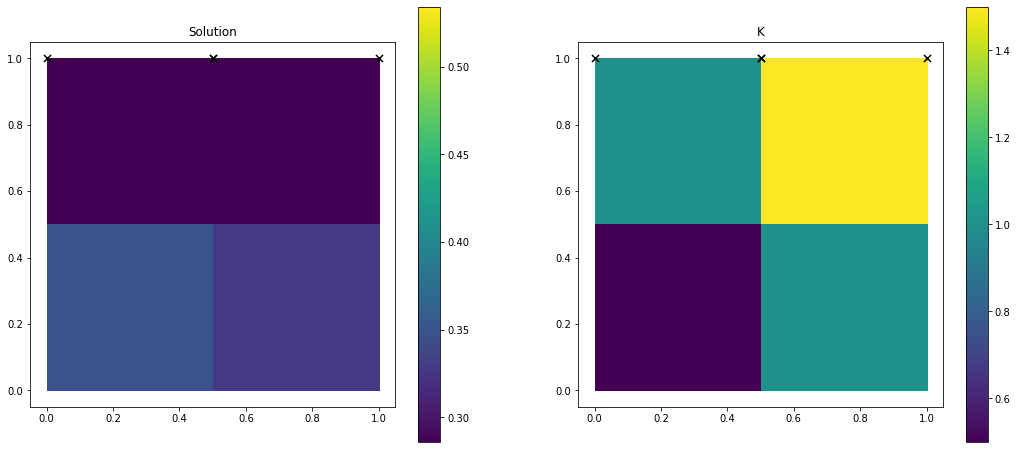

In [8]:
level_coarse = 1
discretization_coarse = fem.Discretization(geometry,level=level_coarse,eval_k=eval_k)
A_coarse = discretization_coarse.setup_stiffness()
rhs_coarse = discretization_coarse.setup_rhs()
#print(A_coarse.todense())
sol_coarse = jacobiRelaxation(A_coarse, rhs_coarse, np.ones(shape = len(rhs_coarse),dtype = float),50)
print("Residual", compute_residual(A_coarse,sol_coarse,rhs_coarse))

plot_solution(geometry=geometry, discretization=discretization_coarse, sol=sol_coarse, level=level_coarse)


## 3. Interpolation

Note that all vertices in the coarse grid also exist in the fine grid.
For these vertices, it is trivial to define the fine grid solution.
The other values need to somehow be inferred. To start we will use a linear interpolation. In a 1D setting this means that we will take half the value at the point to the left and half of the value of the point to the right. 

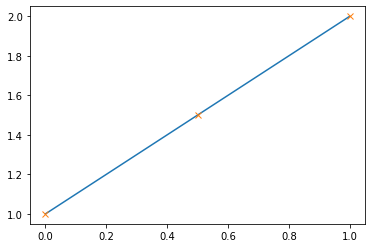

In [9]:
sol_c = [1,2]
sol_f = [1,(1+2)/2,2]
plt.plot(np.linspace(0,1,2), sol_c); 
plt.plot(np.linspace(0,1,3), sol_f,"x"); 
plt.show()

Some notes on other possible choices:
1. choose a constant value (ie either value to the side)
     - usually too small approximation error
     - sometimes used for cell-based coarsening (e.g. for FV methods where the cell values are constants)
2. quadratic, cubic, etc.:
      - often too costly
      - more smoothing steps are cheaper and can eliminate the disadvantage of a lower-order interpolation
      
For our current approximation a linear interpolation is reasonable.

### Interpolation - A small example in matrix notation

This assumes a 1D setup
  
$$
  \left(\begin{array}{ccc}
        \frac{1}{2} & 0 & 0 \\
        1 & 0 & 0 \\
        \frac{1}{2} & \frac{1}{2} & 0 \\
        0 & 1 & 0 \\
        0 & \frac{1}{2} & \frac{1}{2} \\
        0 & 0 & 1 \\
        0 & 0 & \frac{1}{2}\\
     \end{array}\right)
     \left(\begin{array}{c}
        x_1 \\ x_2 \\ x_3
\end{array}\right)
=
     \left(\begin{array}{c}
        \frac{1}{2} (0+x_1) \\ x_1 \\ \frac{1}{2} ( x_1+x_2) \\ x_2 \\ 
        \frac{1}{2} ( x_2+x_3) \\ x_3 \\ \frac{1}{2} (x_3+0)
     \end{array}\right)$$
  
Notation: $I_{2h} x_{2h} = x_h$ or $P_{2h}x_{2h} = x_h$

Note: disregards boundary values (here: 0-Dirichlet condition assumed)

### Interpolation in multiple dimensions

The next step is to define an interpolation operator in multiple dimensions.

The algorithm for building up the interpolation matrix is quite simple:
- Loop through all cells
- Find their parent with cell.parent
- Loop over all vertices (in cell.vertices)
- Find their indices with geometry.vertices_idx_to_coords\[vertex_id\]
- Use evaluate_solution to find the coefficients of the parent's basis functions and set the entry in the matrix.
You basically have to loop through all cells of a given level, and then use the function evaluate_solution to find the coefficients.

In [25]:
# Example of finding vertices:

# Take a random cell
cell = next(geometry.grid.dfs(only_level=1))
print("Found cell with center {center} and size {size}".format(
    center=cell.center, 
    size=cell.size))

# Next we find the parent of the cell
parent = cell.parent
print("Its parent has center {center} and size {size}".format(
    center=parent.center, 
    size=parent.size))

# Our cell has a few vertices:
for i, vertex in enumerate(cell.vertices):
    global_coords = geometry.vertices_idx_to_coords[vertex]
    reference_coords = fem.map_to_reference_coordinates(cell, global_coords)
    print(
        "child's  \t{i}th vertex has index {idx}, data index {data_idx}, global coordinates {global_coords} and reference coordinates {reference_coords}".format(
    i=i,
    idx=vertex,
    data_idx=geometry.vertex_idx_to_data_idx[vertex],
    global_coords=global_coords,
    reference_coords=reference_coords))
    
print()
# The parent also has vertices:
for i, vertex in enumerate(parent.vertices):
    global_coords = geometry.vertices_idx_to_coords[vertex]
    reference_coords = fem.map_to_reference_coordinates(parent, global_coords)
    print(
        "parent's\t{i}th vertex has index {idx}, data index {data_idx},  global coordinates {global_coords} and reference coordinates {reference_coords}".format(
    i=i,
    idx=vertex,
    data_idx=geometry.vertex_idx_to_data_idx[vertex],
    global_coords=global_coords,
    reference_coords=reference_coords))
# Note that the vertices of both cells have the same reference coordinates.     

        
# Now we want to evaluate the basis functions of the parent 
# at the location of the child's vertices.
# We can take the first vertex of the PARENT
first_basis_function_parent = 0
first_vertex_cell = cell.vertices[0]
coordinates_vertex_cell = np.array(geometry.vertices_idx_to_coords[first_vertex_cell])
# Important: We map to the reference coordinates of the PARENT!
reference_coordinates_vertex_cell = fem.map_to_reference_coordinates(parent, coordinates_vertex_cell)

# Show that vertices of level l are subset of vertices of level l+1
def collect_vertex_ids(geometry, level):
    vertex_ids = set()
    data_ids = set()
    # You can iterate through the cells of a level with a depth-first search.
    for cell in geometry.grid.dfs(only_level=level):
        for vertex in cell.vertices:
            vertex_ids.add(vertex)
            if vertex not in geometry.dirichlet_vertices:
                data_ids.add(geometry.vertex_idx_to_data_idx[vertex])
            
    return vertex_ids, data_ids

v_0, d_0 = collect_vertex_ids(geometry, 0)
v_1, d_1 = collect_vertex_ids(geometry, 1)
print("Vertices of level 0 are\t\t{},\nvertices of level 1 are\t\t{}".format(v_0, v_1))
print("Data indices of level 0 are\t{},\ndata indices of level 1 are\t{}".format(d_0, d_1))

Found cell with center [0.25 0.75] and size 0.5
Its parent has center [0.5 0.5] and size 1.0
child's  	0th vertex has index 4, data index 2, global coordinates (0.0, 0.5) and reference coordinates [-1. -1.]
child's  	1th vertex has index 1, data index -1, global coordinates (0.0, 1.0) and reference coordinates [-1.  1.]
child's  	2th vertex has index 5, data index 3, global coordinates (0.5, 0.5) and reference coordinates [ 1. -1.]
child's  	3th vertex has index 6, data index -1, global coordinates (0.5, 1.0) and reference coordinates [1. 1.]

parent's	0th vertex has index 0, data index 0,  global coordinates (0.0, 0.0) and reference coordinates [-1. -1.]
parent's	1th vertex has index 1, data index -1,  global coordinates (0.0, 1.0) and reference coordinates [-1.  1.]
parent's	2th vertex has index 2, data index 1,  global coordinates (1.0, 0.0) and reference coordinates [ 1. -1.]
parent's	3th vertex has index 3, data index -1,  global coordinates (1.0, 1.0) and reference coordinates [1

In [11]:
# needed in FEM, in FD this reduces to evaluating at a vertex
def evaluate_solution(geometry, discretization, cell, coord):
    x, y = fem.map_to_reference_coordinates(cell, coord)
    coeff = dict()
    for linear_index, vert in enumerate(cell.vertices):
        if vert not in geometry.dirichlet_vertices:
            coeff[vert] = fem.lagrange_2d(discretization.nodes_x, linear_index, np.array([x,y]))
    return coeff

def make_interpolation(geometry, level_coarse):
    level_fine = level_coarse + 1
    discretization = fem.Discretization(geometry, level_fine)

    number_of_vertices_coarse = geometry.data_size_per_level[level_coarse]
    number_of_vertices_fine = geometry.data_size_per_level[level_fine]
    
    interpolation = sp.lil_matrix((number_of_vertices_fine, number_of_vertices_coarse), dtype=np.float64)
    
    for cell in geometry.grid.dfs(only_level=level_fine):
        for vert in cell.vertices:
            if vert in geometry.dirichlet_vertices: 
                continue
            data_idx_fine = geometry.vertex_idx_to_data_idx[vert]
            coords = geometry.vertices_idx_to_coords[vert]
            coeffs = evaluate_solution(geometry, discretization, cell.parent, np.array(coords))
            for key, val in coeffs.items():
                data_idx_coarse = geometry.vertex_idx_to_data_idx[key]
                interpolation[data_idx_fine, data_idx_coarse] = val
    return interpolation.tocsc()

interpolation = make_interpolation(geometry, level_coarse=level_coarse)
print(interpolation.todense())

[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.5  0.   0.   0.  ]
 [0.   0.   0.25 0.25 0.   0.  ]
 [0.   0.   0.   0.5  0.   0.  ]
 [0.   0.   0.5  0.5  0.   0.  ]
 [0.   0.   0.   0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.5  0.  ]
 [0.   0.   0.   0.5  0.5  0.  ]
 [0.5  0.   0.5  0.   0.   0.  ]
 [0.25 0.   0.25 0.25 0.   0.25]
 [0.   0.   0.   0.5  0.   0.5 ]
 [0.5  0.   0.   0.   0.   0.5 ]
 [0.   0.25 0.   0.25 0.25 0.25]
 [0.   0.5  0.   0.   0.5  0.  ]
 [0.   0.5  0.   0.   0.   0.5 ]]


### Note
The choice of interpolation operator is very important for the convergence of multigrid methods

See the notebook 2DMultigrid.ipynb for an example where linear interpolation is not appropriate.

For our current setting, the linear interpolation above does well. So we can continue on to trying out the nested iteration.

Residual 0.04183366376133181


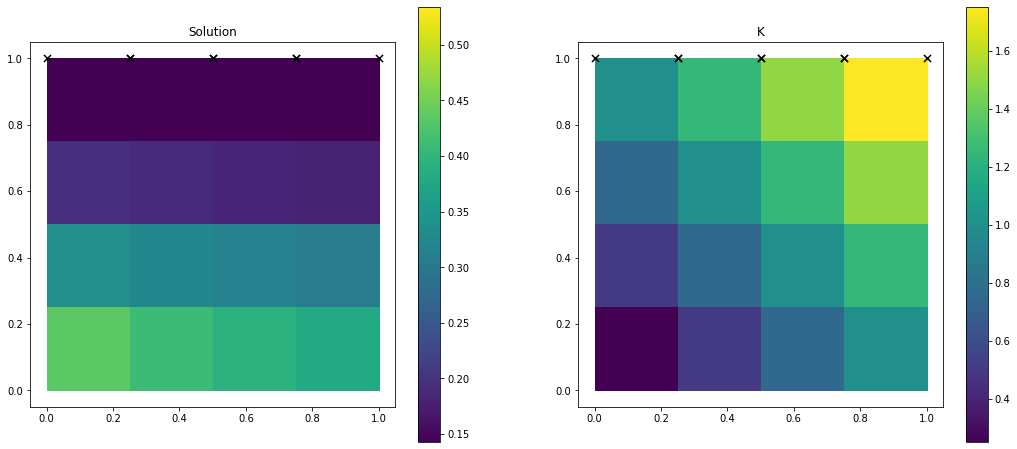

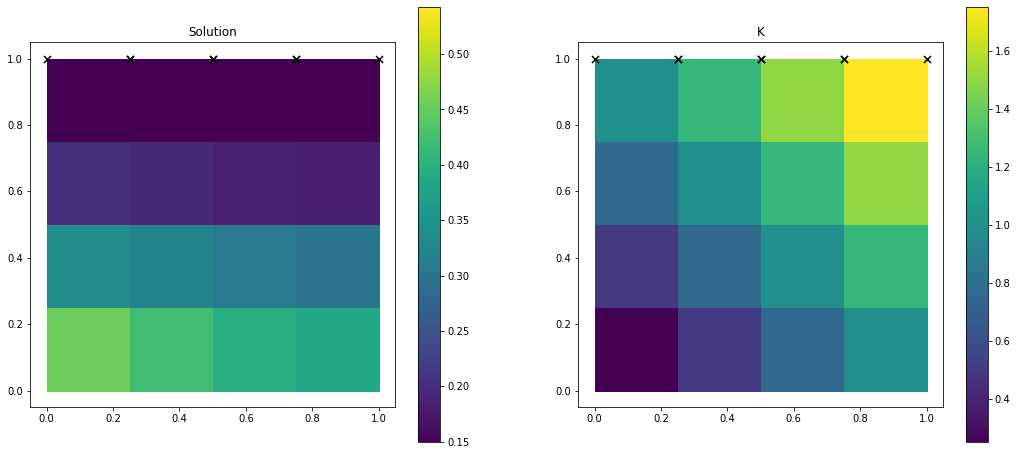

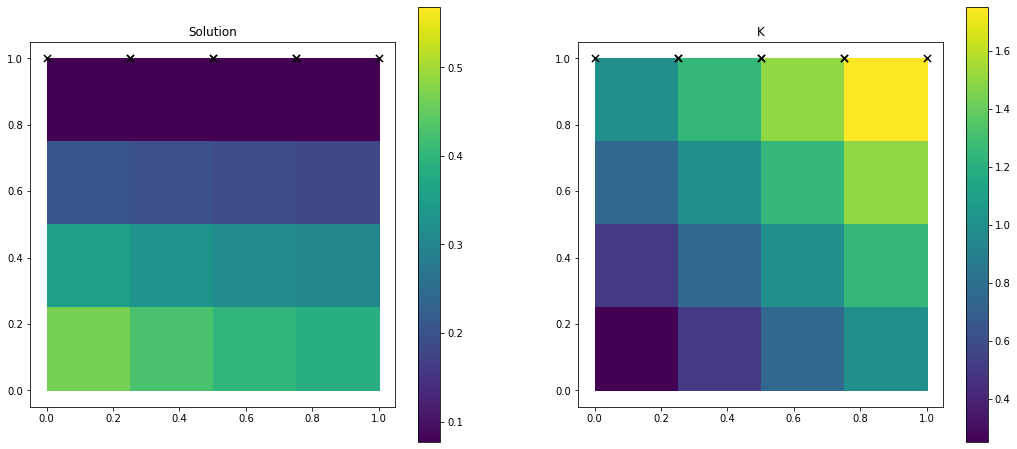

In [26]:
discretization_fine = fem.Discretization(geometry,level=2,eval_k=eval_k)
A_fine = discretization_fine.setup_stiffness()
rhs_fine = discretization_fine.setup_rhs()

initial_guess_fine = interpolation @ sol_coarse
sol_fine = jacobiRelaxation(A_fine, rhs_fine, initial_guess_fine,3)
print("Residual", compute_residual(A_fine,sol_fine, rhs_fine))

plot_solution(geometry=geometry, discretization=discretization_fine, sol=initial_guess_fine, level=2)
plot_solution(geometry=geometry, discretization=discretization_fine, sol=sol_fine, level=2)
plot_solution(geometry=geometry, discretization=discretization_fine, sol=splinalg.linsolve.spsolve(stiffness, rhs), level=2)

## Observation for nested iteration:
The error in interpolated initial guess also includes low frequencies. As a result the relaxation method still converges slowly. Therefore our question is:
- can we go “back” to a coarser grid later in the algorithm?

If we could do that we could correct these remaining low-frequency errors there.

# Multigrid
To start here is some recommended literature on multigrid:
- Briggs, Henson, McCormick: A Multigrid Tutorial (2nd ed.), SIAM, 2000.
- Trottenberg, Oosterlee, Schüller: Multigrid, Elsevier, 2001.
- Shapira: Matrix-Based Multigrid: Theory and Applications, Springer, 2008.
- Hackbusch: Iterative Solution of Large Sparse Systems of Equations, Springer 1993.
- Brandt, Livne: Multigrid Techniques: 1984 Guide with Applications to Fluid Dynamics, Revised Edition, SIAM


## The multigrid idea
Observation and convergence analysis of smoothers have shown us that “high-frequency error” is relative to mesh size and that on a sufficiently coarse grid, even very low frequencies can be “high-frequency” (if the mesh size is big). The main idea of multigrid is now to use multiple grids to solve the system of equations and hope that on each grid, a certain range of error frequencies will be reduced efficiently.

Idea 2: From the previous nested iteration we have learned that we may want to move back and forth between grids. To make this easier we should work only with the residual equation.


## The multigrid idea

##### coarse-grid correction:
1. Solve Ae = r on a coarser grid
2. This leads to an approximation of the error e
3. Add this approximation to the fine-grid solution

### Components
1. smoother: reduce the high-frequency error components, and get a smooth error

2. restriction: transfer residual from fine grid to coarse grid, e.g. injection, (full) weighting
     
3. coarse grid equation: discretisation of the PDE on the coarse grid

4. interpolation: transfer coarse grid solution/correction from coarse grid to fine grid

Of these components we are only missing the restriction.

# Restriction
As for the interpolation many choices of restriction are possible. Perhaps the most intuitive start is injection. Here we simply pick values at corresponding coarse grid points.
However, other choices are possible. For example, the so-called full weighting restriction is simply a transpose of our interpolation. In many cases this is a safer, more robust choice.


### For full weighting (1D):
$$     \frac{1}{2}\left(\!\begin{array}{ccccccc}
        \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0 & 0 & 0\\[0.5ex]
        0 & 0 & \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0\\[0.5ex]
        0 & 0 & 0 & 0 & \frac{1}{2} & 1 & \frac{1}{2}
     \end{array}\!\right) \!\!
     \left(\!\begin{array}{c}
        x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7
     \end{array}\!\right)
     =
     \left(\!\begin{array}{c}
        \frac{1}{4} (x_1+2x_2+x_3) \\[0.5ex] 
        \frac{1}{4} (x_3+2x_4+x_5) \\[0.5ex] 
        \frac{1}{4} (x_5+2x_6+x_7) 
     \end{array}\!\right)$$

Notation: $I_{h}^{2h} x_{h} = x_{2h}$ or $R_h^{2h} x_h = x_{2h}$


### For full weighting (1D):


The restriction matrix is the transpose of the interpolation matrix. Implement this as the function make_restricion, again making sure that the matrix is sparse.

In [13]:
def make_restriction(geometry, level_coarse):
    return make_interpolation(geometry, level_coarse).T

make_restriction(geometry, level_coarse=level_coarse).todense()

matrix([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.5 , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ],
        [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.5 ,
         0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ,
         0.25, 0.  , 0.5 , 0.  , 0.25, 0.5 , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.25, 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 , 0.25, 0.  , 0.5 ]])

### Open questions
- Are there other methods of computing the coarse grid operator than discretisation?

# Coarse Grid Operator
Next, we use the Galerkin construction of the coarse grid operators.
We define the coarse grid operators as
$$A^{2h} = R^{h \to 2h} A^{h} P^{2h \to ih}$$
where $A^{2h}$ is the operator on a grid that's one level smaller than the operator $A^{h}$.
$P^{h \to 2h}$ is the prologation/interpolaton operator that maps a vector from a grid to a grid of the next level and $R^{h \to 2h}$ is the restriction operator that maps to the next coarser grid.


The data structure is already defined below. You need to fill in the blanks and initialize the variables

```
coarse_to_fine
fine_to_coarse
stiffness
```

You can initialize the stiffness matrices by going from the finest grid backwards and computing the coarser operator from the previously computed matrix.

The coarse grid operators that you get from:
- direct discretization on the coarse grid
- Galerkin construction

should be identical up to a constant.

In [14]:
class MultigridStorage:
    def __init__(self, discretization, level_min, level_max, stiffness):
        self.level_min = level_min
        self.level_max = level_max
        
        self.geometry = discretization.geometry
        geometry = discretization.geometry
        
        number_of_levels = (level_max - level_min + 1)
        self.coarse_to_fine = [None] * number_of_levels
        self.fine_to_coarse = [None] * number_of_levels
        self.stiffness = [None] * number_of_levels
        self.stiffness[-1] = stiffness
  
        for level_index in range(number_of_levels - 1, -1, -1):
            level = level_index + level_min
            self.coarse_to_fine[level_index] = \
                make_interpolation(geometry, level_coarse=level-1)
            self.fine_to_coarse[level_index] = make_restriction(geometry, level_coarse=level-1)
            if level != level_max:
                interpolation = make_interpolation(geometry, level_coarse=level)
                restriction = make_restriction(geometry, level_coarse=level)
                self.stiffness[level_index] = \
                 restriction * self.stiffness[level_index+1] * interpolation
                discretization_coarse = fem.Discretization(geometry, level=level, eval_k=discretization.eval_k)
                print(self.stiffness[level_index+1])
                
level = 3
geometry = Geometry(level=level)

eval_k = lambda x, y: x + y + 0.001
discretization = fem.Discretization(geometry, level=level, eval_k=eval_k)
stiffness = discretization.setup_stiffness()
print(stiffness)
rhs = discretization.setup_rhs()
sol = splinalg.linsolve.spsolve(stiffness, rhs)

storage = MultigridStorage(discretization, level_min=1, level_max=level, stiffness=stiffness)

  (0, 0)	0.336
  (53, 0)	-0.08399999999999999
  (54, 0)	-0.168
  (56, 0)	-0.08399999999999999
  (1, 1)	2.6693333333333333
  (69, 1)	-1.3346666666666667
  (70, 1)	-0.6673333333333332
  (71, 1)	-0.6673333333333332
  (2, 2)	3.0053333333333336
  (27, 2)	-0.41733333333333333
  (28, 2)	-0.8346666666666668
  (30, 2)	-0.7513333333333334
  (46, 2)	-0.33399999999999996
  (47, 2)	-0.668
  (3, 3)	10.677333333333333
  (31, 3)	-1.3346666666666667
  (32, 3)	-1.418
  (33, 3)	-1.2513333333333332
  (40, 3)	-1.5013333333333334
  (42, 3)	-1.4180000000000001
  (50, 3)	-1.1680000000000001
  (51, 3)	-1.251333333333333
  (60, 3)	-1.3346666666666667
  (4, 4)	7.6720000000000015
  (43, 4)	-2.0013333333333336
  :	:
  (58, 68)	-0.8346666666666668
  (66, 68)	-0.918
  (67, 68)	-1.0013333333333334
  (68, 68)	3.672
  (1, 69)	-1.3346666666666667
  (17, 69)	-1.3346666666666667
  (18, 69)	-1.5013333333333334
  (19, 69)	-1.1680000000000001
  (65, 69)	-1.418
  (67, 69)	-1.2513333333333332
  (69, 69)	10.677333333333333
  (7

# Outlook: Multigrid

- Generalise the two grid method to an arbitrary number of grids
- Structure remain: smooth $\rightarrow$ restrict $\rightarrow$ interpolate (repeat)
- V-cycle: recursive call of Two-/Multigrid solver on coarse grids
- W-cycle: perform two coarse grid correction steps instead of one

# V-Cycle
We use the following recursive algorithm do define one v-cycle (see A multigrid tutorial Chapter 3 for more details).
The vcycle operator $V^h$ for a grid with spacing $h$, initial guess $v^h$ and right-hand-side $f^h$ is
$$v^h = V^h(v^h,f^h)$$

1. Relax $s_1$ times on $A^h u^h = f^h$
2. If already coarsest grid, go to step 5 (no further iteration possible).
3. Else:

    (Setup rhs for residual equation)

    $$f^{2h} = R^{2h \to h} (f^h - A^h v^h)$$
    
    (Set initial guess for update to zero)
    
    $$v^{2h} = 0$$
    
    (Call vcycle recursively.)
    
    $$v^{2h} = V^{2h} (v^{2h}, f^{2h})$$

4. Correct $$v^h = v^h +P^{2h \to h} v^{2h} $$
5. Relax $s_2$ times on $A^h u^h = f^h$ with initial guess $v^h$.

In [28]:
def v_cycle(storage, level, rhs, unknowns):
    level_index = level - storage.level_min
    restriction = storage.fine_to_coarse[level_index]
    stiffness = storage.stiffness[level_index]
    unknowns = jacobiRelaxation(A=stiffness, b=rhs, x0=unknowns, max_iter=5)
    if level != storage.level_min:
        residual_fine = (rhs - stiffness @ unknowns)
        rhs_coarse = restriction @ residual_fine
        unknowns_coarse = np.zeros(storage.geometry.data_size_per_level[level_index])

        update = v_cycle(storage, level-1, rhs=rhs_coarse, unknowns=unknowns_coarse)
        # Correct
        unknowns += storage.coarse_to_fine[level_index] @ update
    # Don't forget relaxation here!
    unknowns = jacobiRelaxation(A=stiffness, b=rhs, x0=unknowns, max_iter=5)
    return unknowns

In [29]:
# Zero initial guess
unknowns = np.zeros(geometry.data_size_per_level[storage.level_max])
for cycle in range(10):
    unknowns = v_cycle(storage, level=storage.level_max, rhs=rhs, unknowns=unknowns)
    print("Residual after {} \titerations = {},\tError = {}".
          format(
          (cycle+1),
          compute_residual(stiffness, unknowns, rhs),
          np.linalg.norm(sol - unknowns)
          ))

Residual after 1 	iterations = 0.01123717141499085,	Error = 0.0591577670454656
Residual after 2 	iterations = 0.00025070954823932357,	Error = 0.0012945051719702183
Residual after 3 	iterations = 5.703650933277333e-06,	Error = 2.8899049816490047e-05
Residual after 4 	iterations = 1.3148487348095513e-07,	Error = 6.518836940673403e-07
Residual after 5 	iterations = 3.0486964131923956e-09,	Error = 1.4794207733308595e-08
Residual after 6 	iterations = 7.081821429586213e-11,	Error = 3.370280039867232e-10
Residual after 7 	iterations = 1.6443444356429967e-12,	Error = 7.698919102860065e-12
Residual after 8 	iterations = 3.776610666952659e-14,	Error = 1.793905153913528e-13
Residual after 9 	iterations = 2.4834746228126217e-15,	Error = 7.988906186398164e-15
Residual after 10 	iterations = 2.210448884030214e-15,	Error = 4.471189775521543e-15


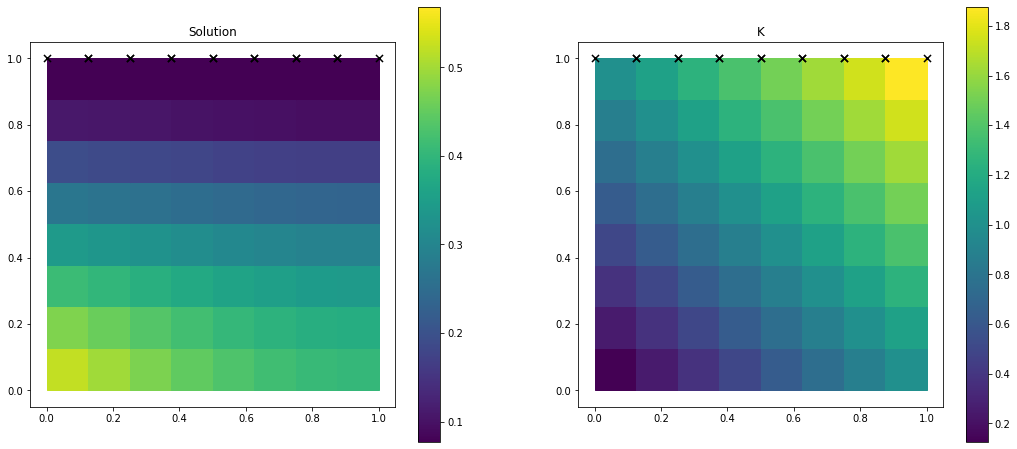

In [17]:
plot_solution(geometry, discretization, unknowns,level=level)

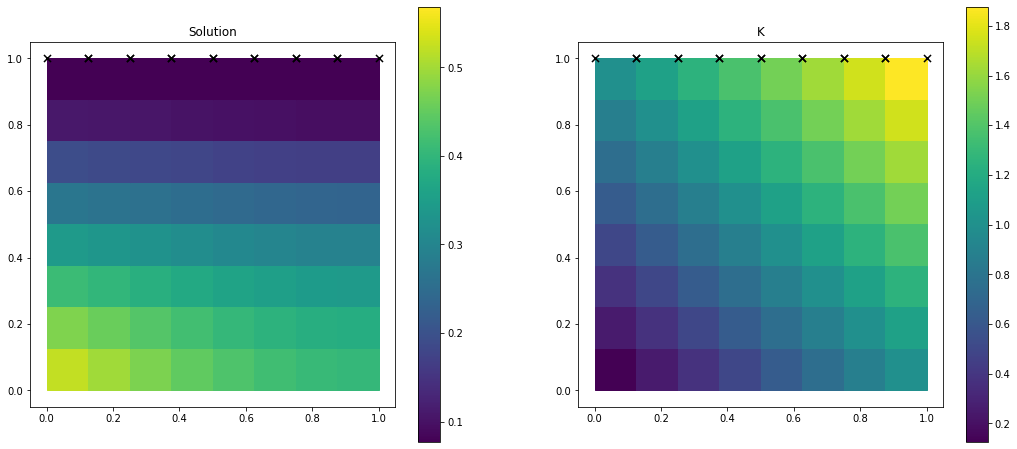

In [18]:
# Compare to "exact" solution
plot_solution(geometry, discretization, sol, level)

In [19]:
initial = np.zeros(geometry.data_size_per_level[storage.level_max])
for it in range(10):
    unknowns = jacobiRelaxation(A=stiffness, x0=initial, b=rhs, max_iter=100*(it+1))
    print("Residual after {} \titerations = {},\tError = {}".
          format(
          (it+1) * 100,
          compute_residual(stiffness, unknowns, rhs),
          np.linalg.norm(sol - unknowns)
          ))

Residual after 100 	iterations = 0.05290435257980684,	Error = 0.3179528359672832
Residual after 200 	iterations = 0.006190775870424455,	Error = 0.03720218720452154
Residual after 300 	iterations = 0.0007243800651490802,	Error = 0.004353011705353238
Residual after 400 	iterations = 8.47593986450789e-05,	Error = 0.0005093440200138974
Residual after 500 	iterations = 9.917660636429444e-06,	Error = 5.959812385057531e-05
Residual after 600 	iterations = 1.160461188527307e-06,	Error = 6.973550738735959e-06
Residual after 700 	iterations = 1.3578506229382944e-07,	Error = 8.159721623424427e-07
Residual after 800 	iterations = 1.588815137876132e-08,	Error = 9.547655213002965e-08
Residual after 900 	iterations = 1.8590651648912637e-09,	Error = 1.1171672044306658e-08
Residual after 1000 	iterations = 2.1752786358978566e-10,	Error = 1.3071940960414796e-09


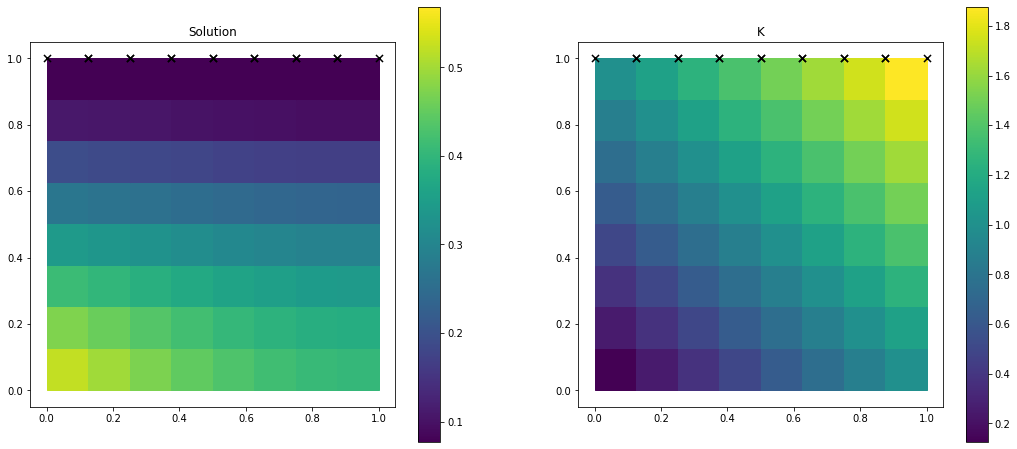

In [20]:
plot_solution(geometry, discretization, unknowns, level)

## Speed of Convergence for multigrid

Multigrid is currently the fastest method around (if all components are chosen carefully), but in practice the best-possible convergence is  often hard to obtain.  



### textbook multigrid efficiency:
$$ \left\| e^{(m+1)} \right\| \le \gamma \left\| e^{(m)} \right\|,$$
where the convergence rate $\gamma < 1$ (esp. $\gamma \ll 1$) is independent of the number of unknowns.
This means in particular, that a constant number of multigrid steps is needed to obtain a given number of digits of accuracy and that the overall computational work increases only linearly with the number of unknowns.

For the simpler model problem we have looked at, the Poisson Problem:
- $\mathcal{O}(n)$ to solve until we have reduced the error by a factor of ...'' ($10^{-8}$, e.g.)

- In many cases we want to solve to an error depending on discretisation error instead. For example $\mathcal{O}(h^2)$. In this case we can solve coarse problems less accurately.


## Speed of Convergence for multigrid

For other problems:
- OK for strongly elliptic problems
- multigrid variants exist for non-linear problems, parabolic/hyperbolic, ...
- every component may fail, leading to slow or no convergence: smoother, interpolation/restriction, coarse-grid operator

Thus, achieving "textbook efficiency" for a new problem is usually a demanding task.

## V-Cycle -- Computational Costs

In order to compute the computational cost of a V-cycle we must first hold down some assumptions:
- the number of unknowns on the coarsest grid is very small, ideally $\mathcal{O}(1)$
- number of smoothing steps is typically very small (1 or 2) and must not depend on problem size

### Computational Costs (storage and computing time):
- 1D: $c\cdot n+c\cdot n/2+c\cdot n/4+\ldots\leq2c\cdot n$

- 2D: $c\cdot n+c\cdot n/4+c\cdot n/16+\ldots\leq4/3c\cdot n$

- 3D: $c\cdot n+c\cdot n/8+c\cdot n/64+\ldots\leq8/7c\cdot n$

 here $n$ the number of grid points on the finest grid: typicall $n = h^{-D}$


Overall the costs are dominated by the costs of the finest grid.

Thus: runtime $\mathcal{O}(n)$ per iteration, but how many iterations necessary?

From our previous note on convergence we know that this number is problem-dependent, but independent of the number of unknowns (under some additional assumputions)!

# The W-cycle
In some cases the coarse grid correction may not be sufficiently accurate. Here we want to spend more time on the coarse grid. This means we perform two coarse grid correction steps instead of one.

<img src=vcycle.png></img>

*Note:* this is just one small change to the V-cycle

# The Full Multigrid V-Cycle (FMV- or F-Cycle)

Another alternative to the V and W-cycles, is the so-called full-multigrid V-cycle or F-cycle. This is given by a recursive algorithm. It is essentially just a combination of the nested iteration and a V-cycle. We (recursively!) perform an FMV-cycle on the next coarser grid to 
        get a good initial solution. Then we interpolate this initial guess to the current grid and finally perform a V-cycle to improve the solution

<img src=fullcycle.png></img>

